Loaded dataset: 211 × 40 from 'C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv'
Unified survival: N=211 (events=63)


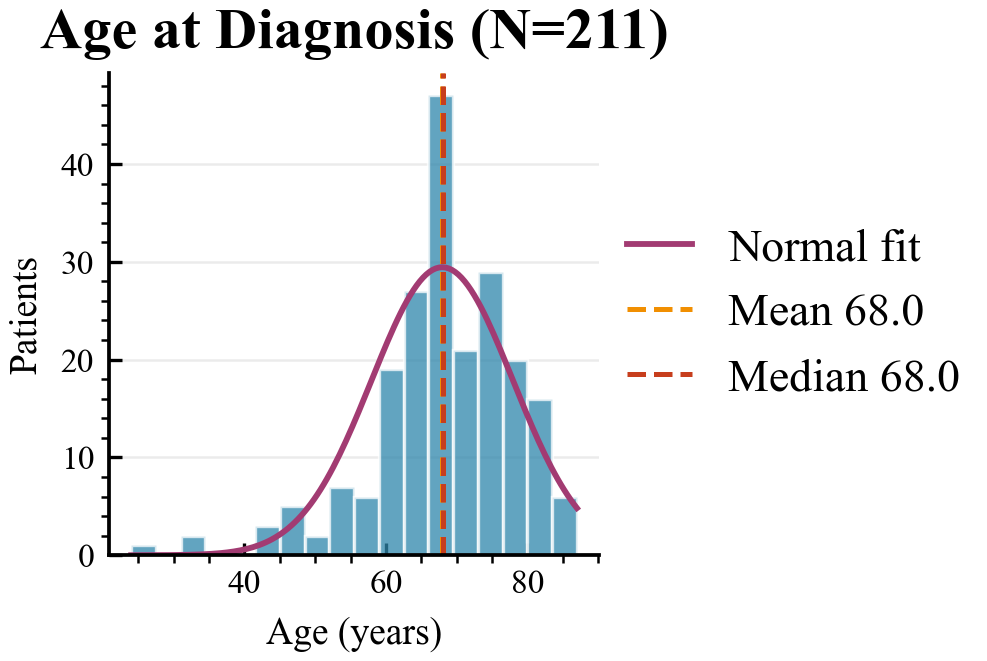

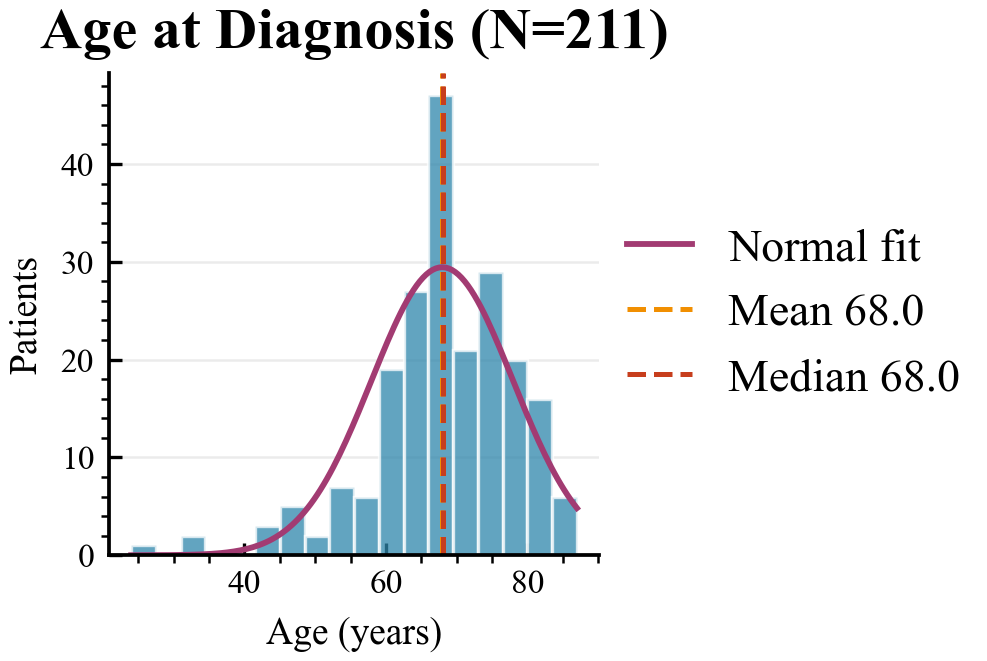

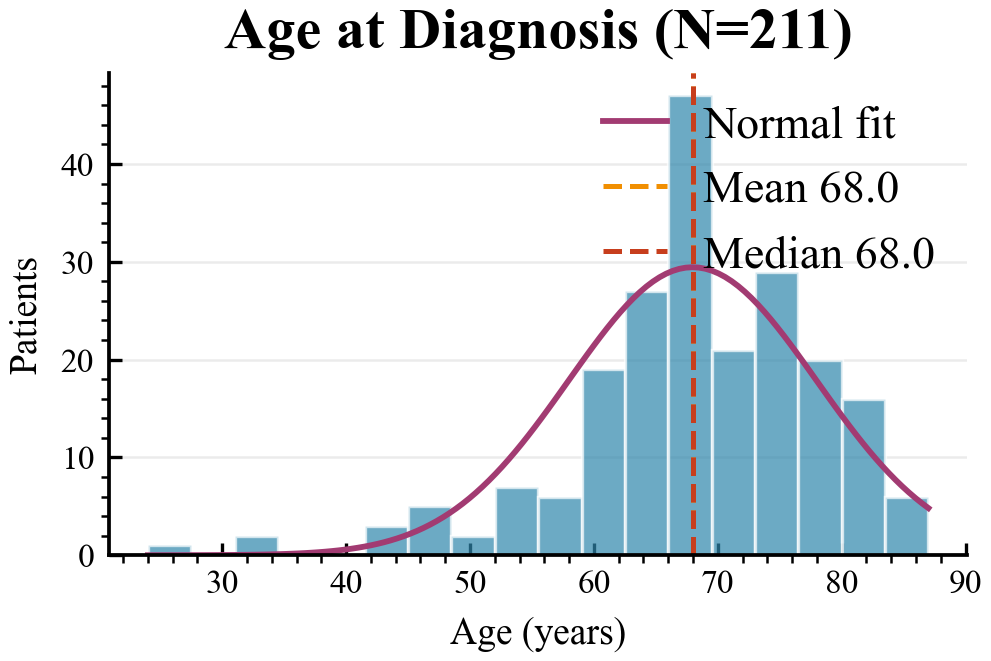

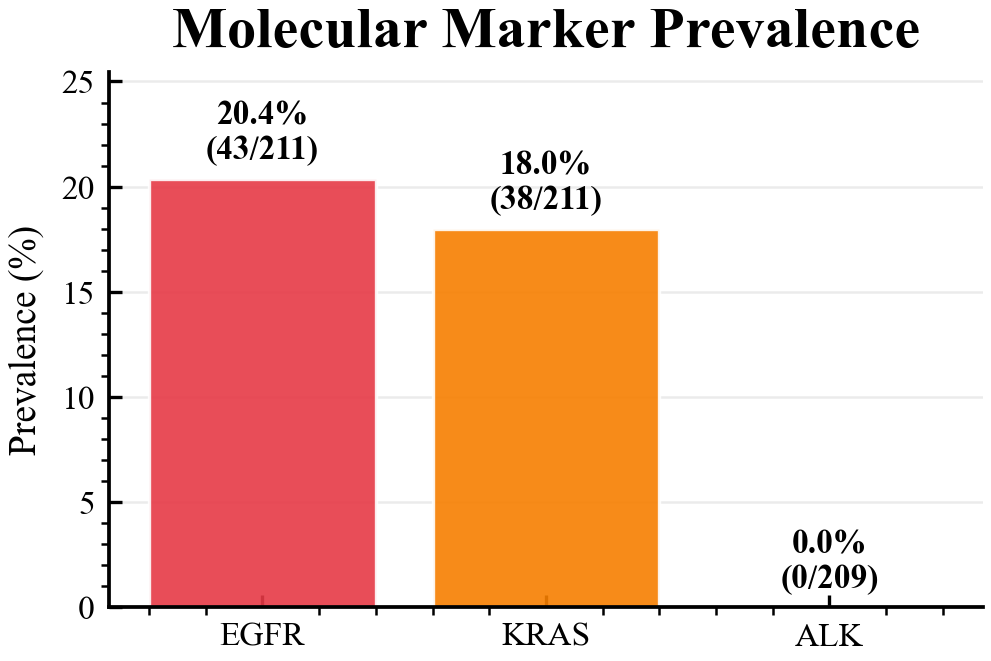

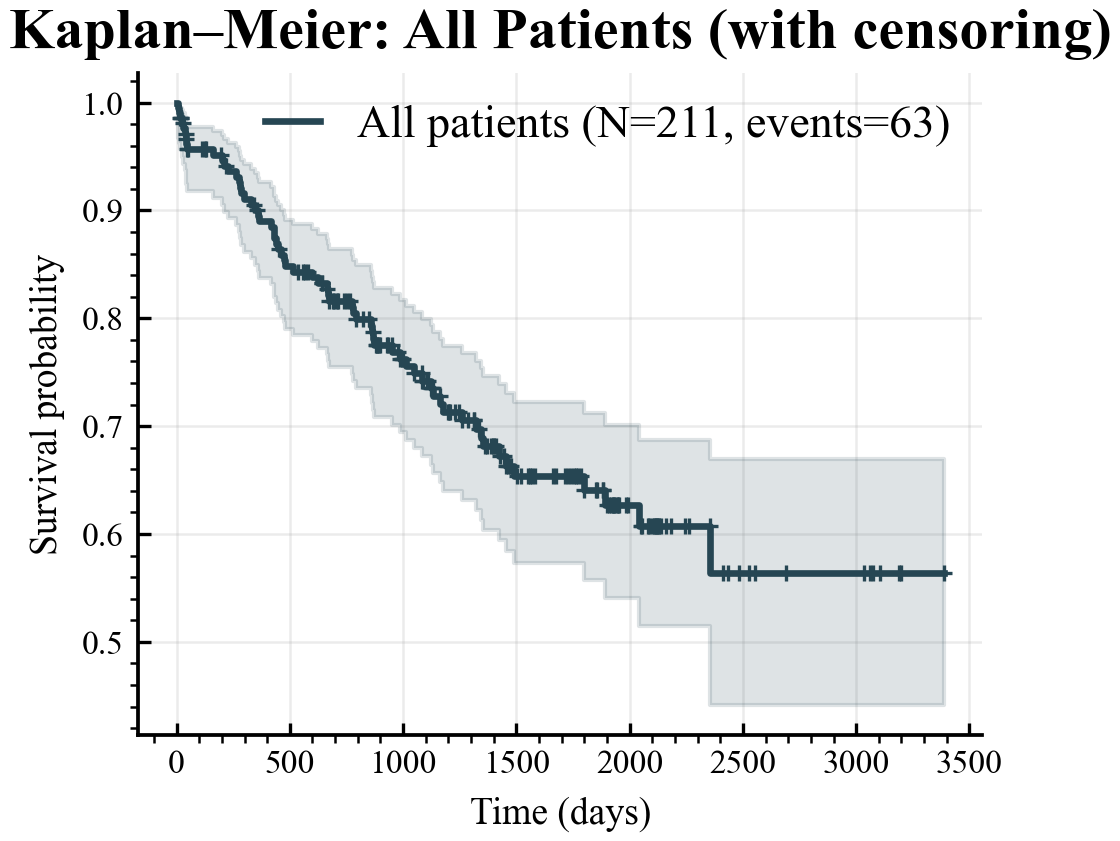

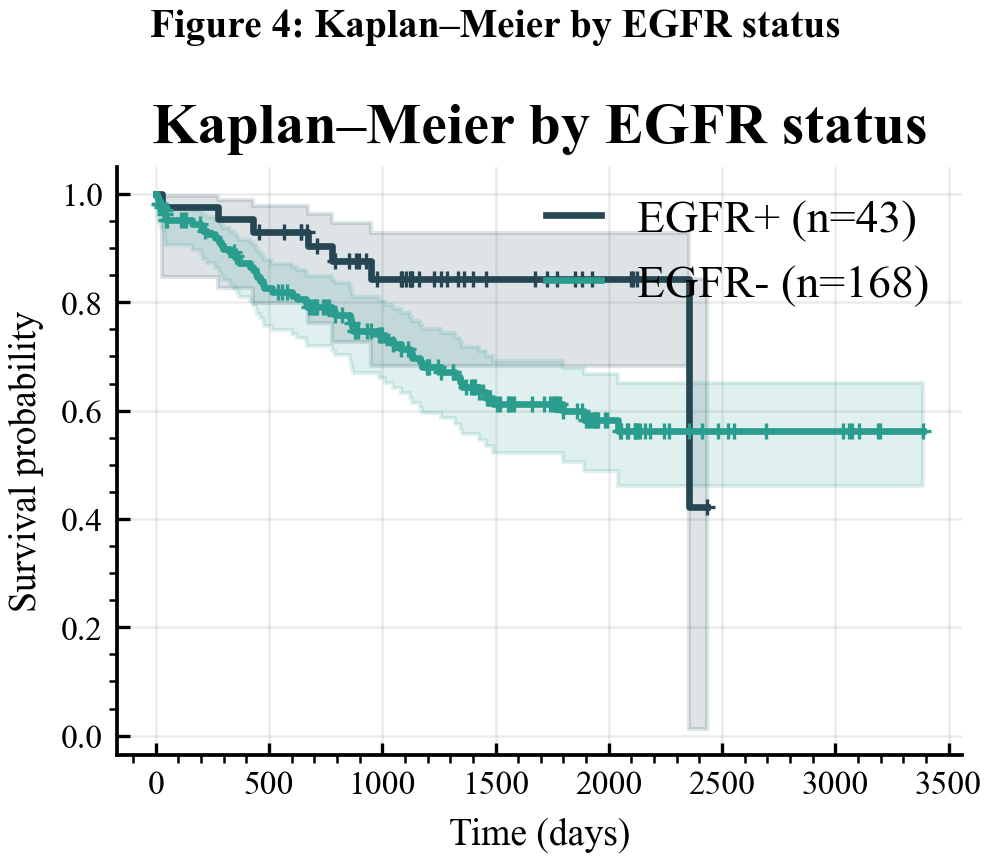

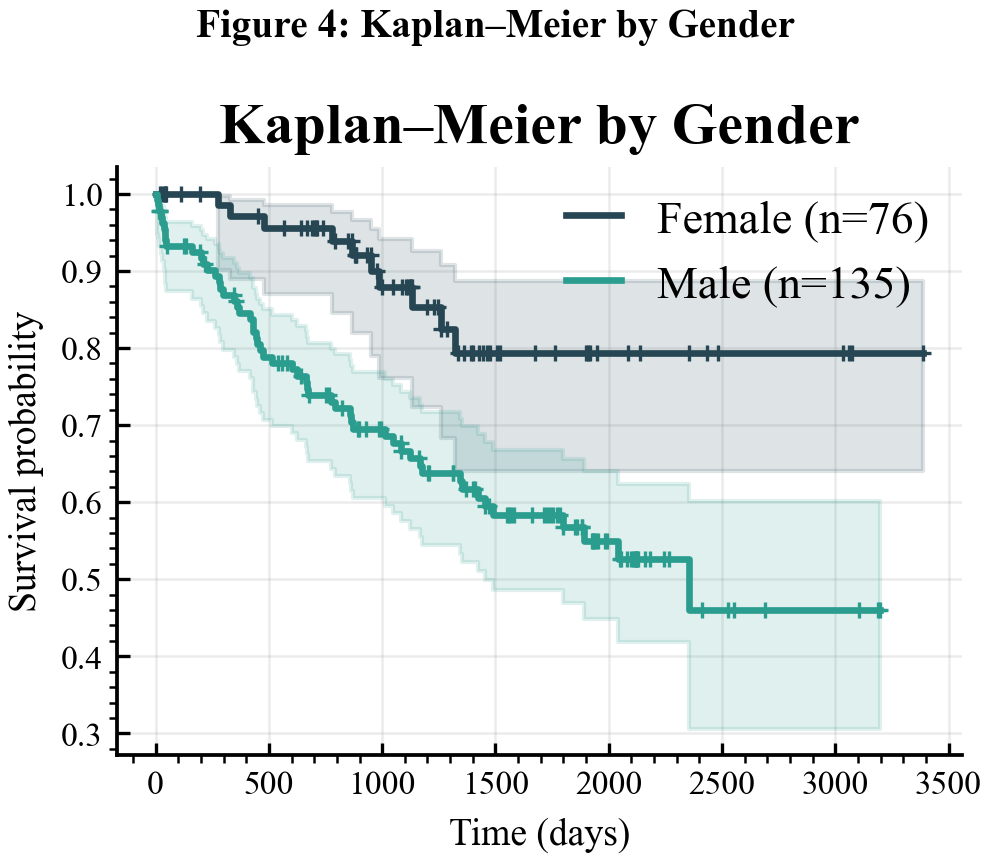

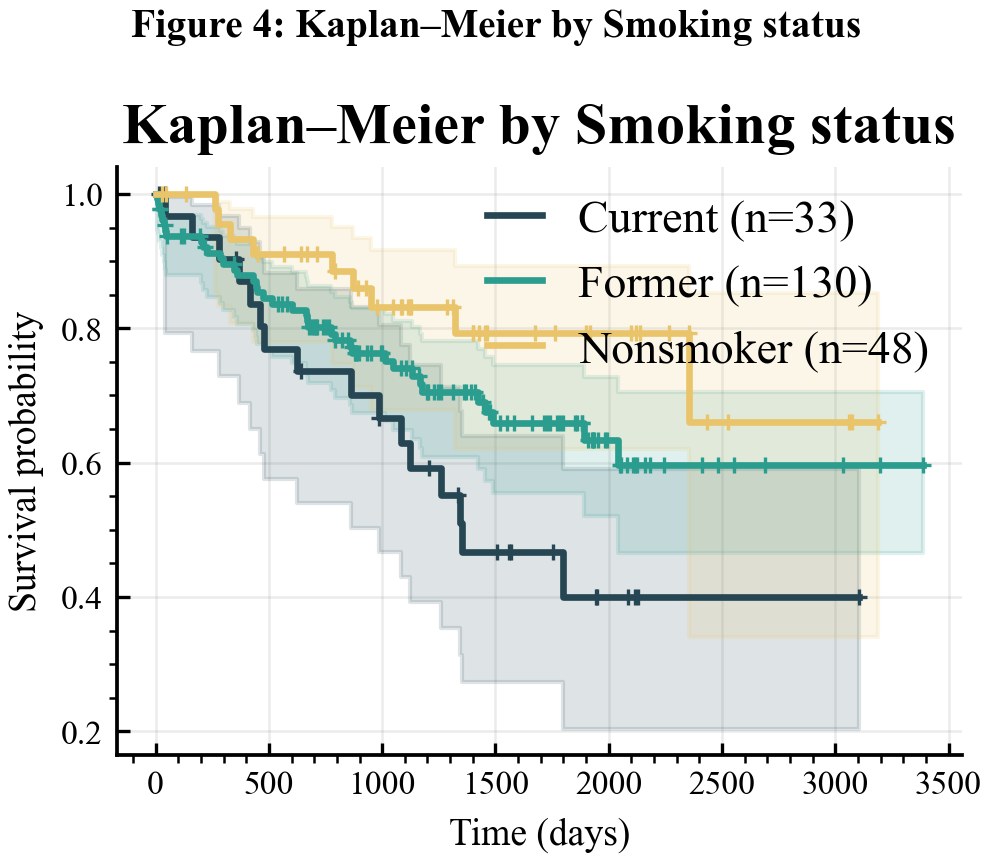

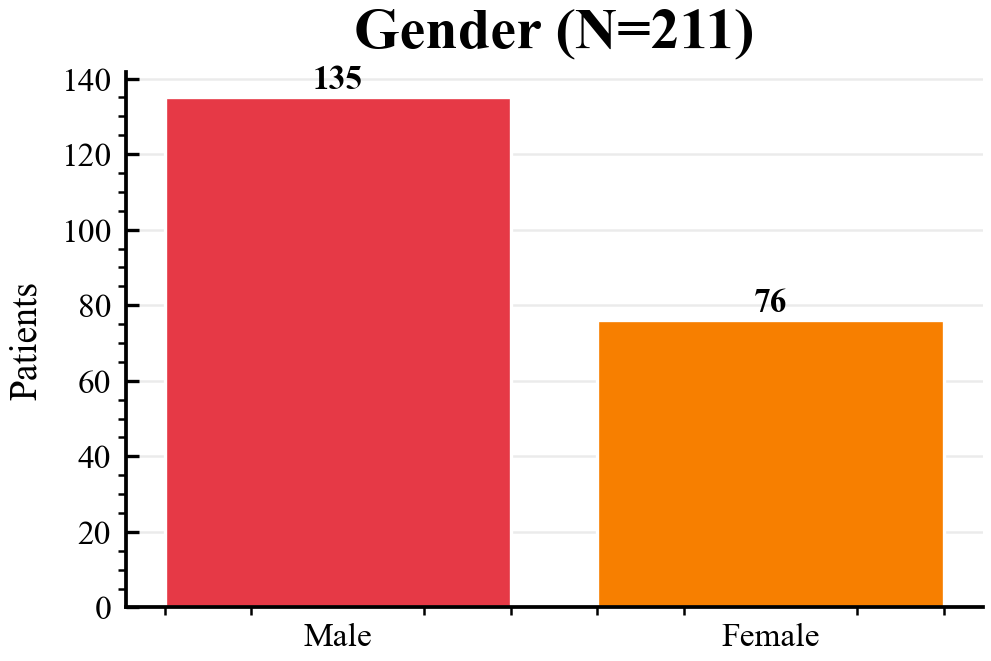

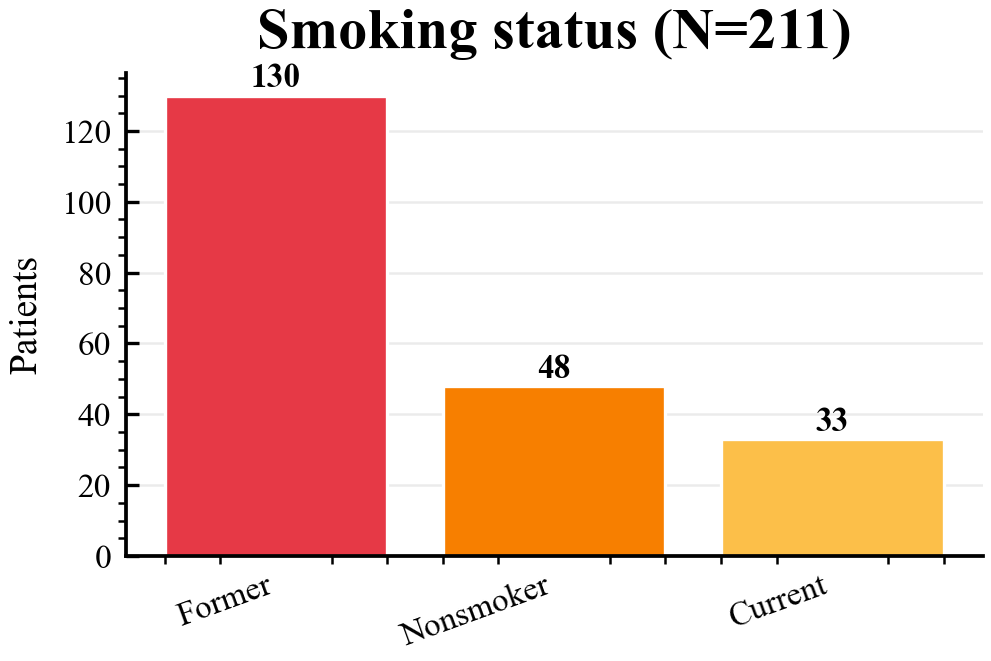

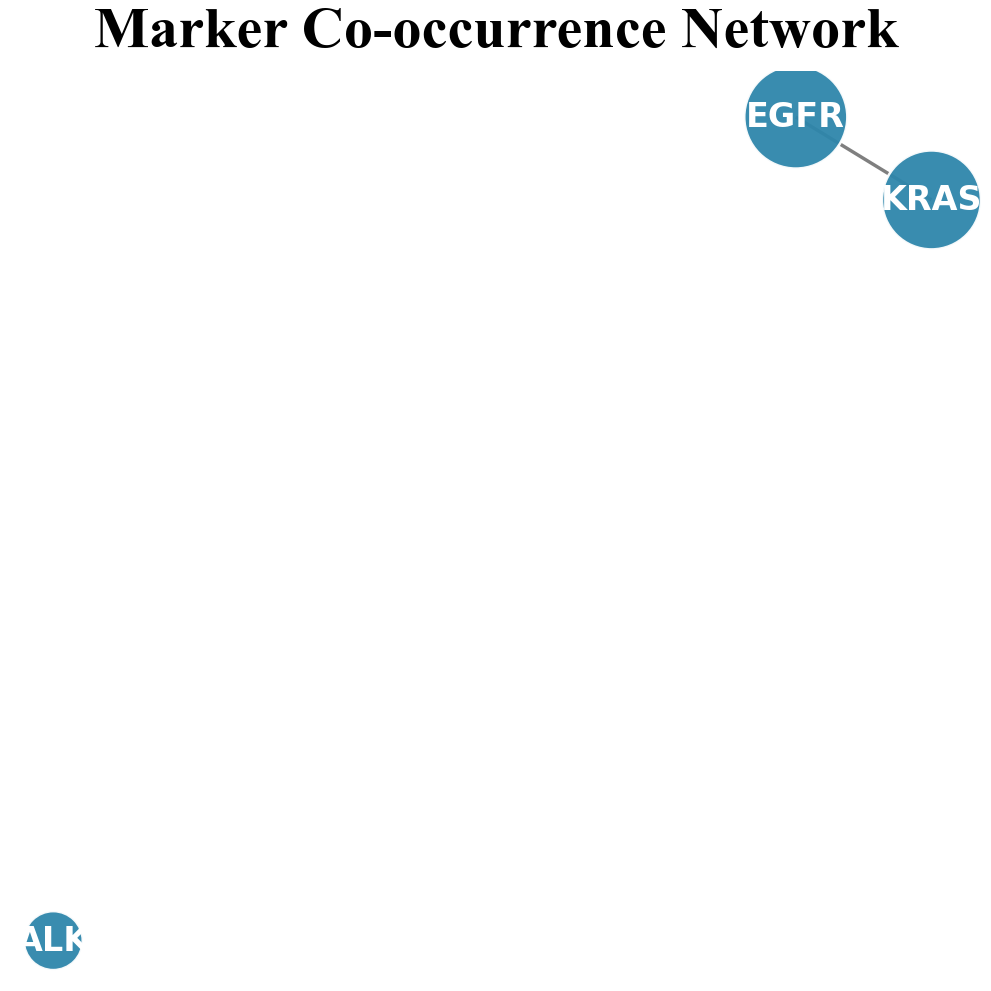

Done. Compact figures saved under ./figures/


In [10]:
"""
Enhanced NSCLC Radiogenomic Analysis — Compact Journal-Ready Plots
==================================================================

Dataset-tailored version for NSCLCR01Radiogenomic_.csv (N≈211).

Survival construction (to include ALL patients with censoring):
  SurgeryDate = CT Date + 'Days between CT and surgery'
  Alive: OS_time = (Date of Last Known Alive - SurgeryDate).days, OS_event = 0
  Dead : OS_time = 'Time to Death (days)' (fallback: Date of Death - SurgeryDate), OS_event = 1
  Missing/negative times are set to 0 so nobody is dropped.

Outputs:
- Each plot is a single, compact, publication-ready figure (shown and saved to ./figures/).
- KM curves include censor marks, thinner lines, and subtle CIs for print.
- Default path uses your Windows file; also tries attached path and fallbacks.

Author: Enhanced Statistical Analysis Pipeline
Date: 2024
"""

import os
import glob
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Survival analysis
try:
    from lifelines import KaplanMeierFitter
    LIFELINES_AVAILABLE = True
except ImportError:
    LIFELINES_AVAILABLE = False

# =========================================
# CONFIG
# =========================================

# Your Windows path (raw string; backslashes safe)
DEFAULT_CSV = r"C:\Users\awwal\Desktop\MLEA_experiments\NSCLCR01Radiogenomic_.csv"
# Also try the attached path (for notebook/hosted runs)
ATTACHED_PATH = "/mnt/data/NSCLCR01Radiogenomic_.csv"

SHOW_FIGS = True
SAVE_DIR = "figures"
os.makedirs(SAVE_DIR, exist_ok=True)

# Base rcParams (then we’ll override per-figure with compact context)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'figure.dpi': 300,
    'savefig.dpi': 600,
    'savefig.format': 'png',
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.03,
    'axes.linewidth': 0.9,
    'lines.linewidth': 1.6,
    'patch.linewidth': 0.8,
    'grid.alpha': 0.25,
    'grid.linewidth': 0.6,
})

# Journal-ish sizes (inches): single column ~3.5"; square for networks/KM
FIG_SIZES = {
    'one_col':       (3.5, 2.4),
    'one_col_tall':  (3.5, 3.0),
    'square':        (3.5, 3.5),
    'wide_short':    (7.2, 2.8),  # optional two-column wide
}

# Compact font/tick tuning for print readability
COMPACT_RC = {
    'font.size': 8.5,
    'axes.labelsize': 9.0,
    'axes.titlesize': 9.5,
    'xtick.labelsize': 8.0,
    'ytick.labelsize': 8.0,
    'legend.fontsize': 8.0,
    'legend.title_fontsize': 8.0,
}

PUBLICATION_COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent1': '#F18F01',
    'accent2': '#C73E1D',
    'neutral':  '#6C757D',
    'molecular': ['#E63946', '#F77F00', '#FCBF49', '#06D6A0', '#118AB2', '#073B4C'],
    'survival':  ['#264653', '#2A9D8F', '#E9C46A', '#F4A261', '#E76F51']
}

VERBOSE = True
def log(msg: str):
    if VERBOSE:
        print(msg)

# =========================================
# HELPERS
# =========================================

def setup_publication_plot(size_key='one_col'):
    """Create a compact, journal-style figure/axes using a named size preset."""
    figsize = FIG_SIZES.get(size_key, FIG_SIZES['one_col'])
    with plt.rc_context(COMPACT_RC):
        fig, ax = plt.subplots(figsize=figsize)
        # Aesthetics: minimal frame, inward ticks, light grid on y only
        for spine in ('top', 'right'):
            ax.spines[spine].set_visible(False)
        ax.spines['left'].set_linewidth(0.9)
        ax.spines['bottom'].set_linewidth(0.9)
        ax.tick_params(direction='in', length=3.0, width=0.8)
        ax.minorticks_on()
        ax.grid(True, axis='y', alpha=0.25, linewidth=0.6, linestyle='-')
        ax.grid(False, axis='x')
        ax.set_axisbelow(True)
    return fig, ax

def save_and_optionally_show(fig, fname_base, title=None):
    with plt.rc_context(COMPACT_RC):
        if title:
            fig.suptitle(title, fontsize=9.5, fontweight='bold', y=0.98)
        plt.tight_layout()
        png = os.path.join(SAVE_DIR, f"{fname_base}.png")
        pdf = os.path.join(SAVE_DIR, f"{fname_base}.pdf")
        fig.savefig(png, dpi=600, bbox_inches='tight', facecolor='white')
        fig.savefig(pdf, dpi=600, bbox_inches='tight', facecolor='white')
        if SHOW_FIGS:
            plt.show()
        plt.close(fig)

# =========================================
# DATA PREP TAILORED TO THIS CSV
# =========================================

COLS = {
    'age': 'Age at Histological Diagnosis',
    'gender': 'Gender',
    'smoke': 'Smoking status',
    'egfr': 'EGFR mutation status',
    'kras': 'KRAS mutation status',
    'alk':  'ALK translocation status',
    'surv_status': 'Survival Status',
    't_death_days': 'Time to Death (days)',
    'date_alive': 'Date of Last Known Alive',
    'date_death': 'Date of Death',
    'ct_date': 'CT Date',
    'days_ct_to_surg': 'Days between CT and surgery',
}

def _parse_dates_inplace(df, cols):
    for c in cols:
        if c in df.columns:
            df[c + '_dt'] = pd.to_datetime(df[c], errors='coerce')

def _map_marker_value(x):
    s = str(x).strip().lower()
    if any(k in s for k in ['positive', 'mutant', 'mut', 'rearranged', '1', 'yes']):
        return 1
    if any(k in s for k in ['negative', 'wild', '0', 'no']):
        return 0
    return np.nan

def build_os_time_event(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create OS_time (days) and OS_event (1=death, 0=censored) using the dataset's schema.
    Ensures ALL patients are included; missing values default to 0 days, censored if status unknown.
    """
    df = df.copy()

    # Event from 'Survival Status'
    if COLS['surv_status'] in df.columns:
        df['Death_Status'] = df[COLS['surv_status']].astype(str).str.lower().map({'dead': 1, 'alive': 0})
    df['Death_Status'] = pd.to_numeric(df.get('Death_Status', np.nan), errors='coerce').fillna(0).astype(int)

    # Parse dates
    _parse_dates_inplace(df, [COLS['ct_date'], COLS['date_alive'], COLS['date_death']])

    # Surgery date
    if COLS['days_ct_to_surg'] in df.columns:
        df['Days_between_CT_surg_num'] = pd.to_numeric(df[COLS['days_ct_to_surg']], errors='coerce')
    else:
        df['Days_between_CT_surg_num'] = np.nan
    df['SurgeryDate'] = df.get(COLS['ct_date'] + '_dt', pd.NaT) + pd.to_timedelta(df['Days_between_CT_surg_num'], unit='D')

    # Initialize time
    df['OS_time'] = np.nan

    # Alive patients: time to last known alive
    alive_mask = df['Death_Status'] == 0
    if COLS['date_alive'] + '_dt' in df.columns:
        df.loc[alive_mask, 'OS_time'] = (df.loc[alive_mask, COLS['date_alive'] + '_dt'] - df.loc[alive_mask, 'SurgeryDate']).dt.days

    # Dead patients: use explicit "Time to Death (days)" when present
    if COLS['t_death_days'] in df.columns:
        df[COLS['t_death_days']] = pd.to_numeric(df[COLS['t_death_days']], errors='coerce')
        dead_mask = df['Death_Status'] == 1
        df.loc[dead_mask, 'OS_time'] = df.loc[dead_mask, COLS['t_death_days']]

    # Fallback for dead: Date of Death - SurgeryDate
    if COLS['date_death'] + '_dt' in df.columns:
        fb_mask = (df['Death_Status'] == 1) & df['OS_time'].isna()
        if fb_mask.any():
            df.loc[fb_mask, 'OS_time'] = (df.loc[fb_mask, COLS['date_death'] + '_dt'] - df.loc[fb_mask, 'SurgeryDate']).dt.days

    # Clean up: keep everyone
    df['OS_time'] = pd.to_numeric(df['OS_time'], errors='coerce').fillna(0)
    df.loc[df['OS_time'] < 0, 'OS_time'] = 0
    df['OS_event'] = df['Death_Status'].astype(int)

    return df

def preprocess_dataset(df: pd.DataFrame):
    """Minimal preprocessing: binarize markers and unify survival."""
    dfc = df.copy()

    # Markers to 0/1
    for src, dst in [(COLS['egfr'], 'EGFR_Positive'),
                     (COLS['kras'], 'KRAS_Positive'),
                     (COLS['alk'],  'ALK_Positive')]:
        if src in dfc.columns:
            dfc[dst] = dfc[src].map(_map_marker_value)

    # Build OS_time/event
    dfc = build_os_time_event(dfc)

    report = {
        'n_patients': len(dfc),
        'n_events': int(dfc['OS_event'].sum())
    }
    return dfc, report

# =========================================
# FIGURES (compact, single-plot outputs)
# =========================================

def plot_age_distribution(df):
    col = COLS['age']
    if col not in df.columns:
        return
    age = pd.to_numeric(df[col], errors='coerce').dropna()
    if age.empty:
        return

    desc = age.describe()
    fig, ax = setup_publication_plot(size_key='one_col')
    counts, bins, _ = ax.hist(
        age, bins=18, alpha=0.7, color=PUBLICATION_COLORS['primary'],
        edgecolor='white', linewidth=0.8
    )
    mu, sd = desc['mean'], desc['std']
    if pd.notna(sd) and sd > 0:
        x = np.linspace(age.min(), age.max(), 120)
        y = (1/(np.sqrt(2*np.pi)*sd)) * np.exp(-0.5*((x-mu)/sd)**2) * len(age) * (bins[1]-bins[0])
        ax.plot(x, y, color=PUBLICATION_COLORS['secondary'], linewidth=1.4, label='Normal fit')

    ax.axvline(mu, color=PUBLICATION_COLORS['accent1'], linestyle='--', linewidth=1.2, label=f"Mean {mu:.1f}")
    ax.axvline(desc['50%'], color=PUBLICATION_COLORS['accent2'], linestyle='--', linewidth=1.2, label=f"Median {desc['50%']:.1f}")
    ax.set_xlabel('Age (years)')
    ax.set_ylabel('Patients')
    ax.set_title(f'Age at Diagnosis (N={len(age)})', fontweight='bold')

    # Compact legend
    leg = ax.legend(loc='upper right', frameon=False, handlelength=1.4, borderpad=0.2)
    save_and_optionally_show(fig, "01_age_distribution")

def plot_molecular_prevalence(df):
    markers = [c for c in ['EGFR_Positive', 'KRAS_Positive', 'ALK_Positive'] if c in df.columns]
    if not markers:
        return
    rows = []
    for m in markers:
        total = df[m].notna().sum()
        pos = df[m].fillna(0).astype(int).sum()
        p = 100 * pos / total if total > 0 else 0
        rows.append((m.replace('_Positive', ''), pos, total, p))
    if not rows:
        return

    labels, pos, total, perc = zip(*rows)
    fig, ax = setup_publication_plot(size_key='one_col')
    bars = ax.bar(
        labels, perc,
        color=PUBLICATION_COLORS['molecular'][:len(labels)],
        alpha=0.9, edgecolor='white', linewidth=0.8
    )
    for i, b in enumerate(bars):
        ax.text(
            b.get_x() + b.get_width()/2, b.get_height() + (0.03*max(perc) if max(perc)>0 else 0.5),
            f"{b.get_height():.1f}%\n({pos[i]}/{total[i]})",
            ha='center', va='bottom', fontweight='bold', fontsize=8
        )
    ax.set_ylim(0, max(perc)*1.25 if max(perc) > 0 else 10)
    ax.set_ylabel('Prevalence (%)')
    ax.set_title('Molecular Marker Prevalence', fontweight='bold')
    save_and_optionally_show(fig, "02_molecular_prevalence")

def plot_survival_km_all(df):
    """Single KM curve including ALL patients, with censoring."""
    if not LIFELINES_AVAILABLE:
        log("lifelines not available; skipping KM.")
        return
    if 'OS_time' not in df.columns or 'OS_event' not in df.columns:
        return

    data = df[['OS_time', 'OS_event']].copy()
    data['OS_event'] = data['OS_event'].fillna(0).astype(int)
    data['OS_time']  = data['OS_time'].fillna(0)

    total_n = len(data)
    events_total = int(data['OS_event'].sum())

    fig, ax = setup_publication_plot(size_key='one_col_tall')
    kmf = KaplanMeierFitter()
    kmf.fit(
        data['OS_time'], event_observed=data['OS_event'],
        label=f"All patients (N={total_n}, events={events_total})"
    )
    # Lifelines' plot (compact tweaks)
    kmf.plot(
        ax=ax, ci_show=True, show_censors=True,
        censor_styles={'marker': '+', 'ms': 4.0, 'mew': 0.8},
        color=PUBLICATION_COLORS['survival'][0],
        ci_alpha=0.15,
    )
    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Survival probability')
    ax.set_title('Kaplan–Meier: All Patients (with censoring)', fontweight='bold')
    # Tight legend
    ax.legend(loc='upper right', frameon=False, handlelength=1.2, borderpad=0.2)
    save_and_optionally_show(fig, "03_survival_km_all")

def plot_survival_km_grouped(df, group_by='EGFR_Positive', pretty_map=None, fname_suffix=None, title_suffix=None):
    """Optional grouped KM curves (all included; Unknown forms a group)."""
    if not LIFELINES_AVAILABLE:
        return
    if 'OS_time' not in df.columns or 'OS_event' not in df.columns or group_by not in df.columns:
        return

    data = df[['OS_time', 'OS_event', group_by]].copy()
    data['OS_event'] = data['OS_event'].fillna(0).astype(int)
    data['OS_time']  = data['OS_time'].fillna(0)

    if pretty_map is not None:
        data[group_by] = data[group_by].map(pretty_map)
    else:
        if group_by.endswith('_Positive'):
            base = group_by.replace('_Positive','')
            data[group_by] = data[group_by].map({1: f"{base}+", 0: f"{base}-"})
    data[group_by] = data[group_by].fillna('Unknown').astype(str)

    fig, ax = setup_publication_plot(size_key='one_col_tall')
    kmf = KaplanMeierFitter()
    palette = PUBLICATION_COLORS['survival']
    for i, (grp, sub) in enumerate(data.groupby(group_by)):
        if len(sub) == 0:
            continue
        kmf.fit(sub['OS_time'], event_observed=sub['OS_event'], label=f"{grp} (n={len(sub)})")
        kmf.plot(
            ax=ax, ci_show=True, show_censors=True,
            censor_styles={'marker': '+', 'ms': 4.0, 'mew': 0.8},
            color=palette[i % len(palette)],
            ci_alpha=0.15,
        )
    ax.set_xlabel('Time (days)'); ax.set_ylabel('Survival probability')
    title = f"Kaplan–Meier by {group_by}" if not title_suffix else f"Kaplan–Meier by {title_suffix}"
    ax.set_title(title, fontweight='bold')
    ax.legend(loc='upper right', frameon=False, handlelength=1.2, borderpad=0.2)
    save_and_optionally_show(
        fig,
        f"04_survival_km_by_{fname_suffix or group_by.lower()}",
        f"Figure 4: {title}"
    )

def plot_demographics(df):
    # Gender (single compact bar)
    if COLS['gender'] in df.columns:
        g = df[COLS['gender']].dropna()
        if not g.empty:
            counts = g.value_counts()
            fig, ax = setup_publication_plot(size_key='one_col')
            bars = ax.bar(
                counts.index.astype(str), counts.values,
                color=PUBLICATION_COLORS['molecular'][:len(counts)],
                edgecolor='white', linewidth=0.8
            )
            for b in bars:
                ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5,
                        f"{int(b.get_height())}", ha='center', va='bottom', fontweight='bold', fontsize=8)
            ax.set_title(f"Gender (N={len(g)})", fontweight='bold'); ax.set_ylabel('Patients')
            save_and_optionally_show(fig, "05_demographics_gender")

    # Smoking (single compact bar)
    if COLS['smoke'] in df.columns:
        s = df[COLS['smoke']].dropna()
        if not s.empty:
            counts = s.value_counts()
            fig, ax = setup_publication_plot(size_key='one_col')
            bars = ax.bar(
                counts.index.astype(str), counts.values,
                color=PUBLICATION_COLORS['molecular'][:len(counts)],
                edgecolor='white', linewidth=0.8
            )
            for b in bars:
                ax.text(b.get_x() + b.get_width()/2, b.get_height() + 0.5,
                        f"{int(b.get_height())}", ha='center', va='bottom', fontweight='bold', fontsize=8)
            ax.set_title(f"Smoking status (N={len(s)})", fontweight='bold'); ax.set_ylabel('Patients')
            plt.setp(ax.get_xticklabels(), rotation=20, ha='right')
            save_and_optionally_show(fig, "06_demographics_smoking", )

def plot_marker_network(df):
    import networkx as nx
    from itertools import combinations

    markers = [m for m in ['EGFR_Positive', 'KRAS_Positive', 'ALK_Positive'] if m in df.columns]
    if len(markers) < 2:
        return
    data = df[markers].dropna().astype(int)
    if data.empty:
        return

    G = nx.Graph()
    for m in markers:
        rate = data[m].mean()
        G.add_node(m.replace('_Positive',''), size=200 + 2000*rate)

    for a, b in combinations(markers, 2):
        both = ((data[a] == 1) & (data[b] == 1)).mean()
        if both > 0:
            G.add_edge(a.replace('_Positive',''), b.replace('_Positive',''), weight=0.8 + 5*both)

    pos = nx.spring_layout(G, seed=42)
    fig, ax = setup_publication_plot(size_key='square')
    nx.draw_networkx_edges(G, pos, ax=ax, width=[G[u][v]['weight'] for u, v in G.edges()], alpha=0.5)
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_size=[G.nodes[n]['size'] for n in G.nodes()],
                           node_color=PUBLICATION_COLORS['primary'],
                           linewidths=0.6, edgecolors='white', alpha=0.95)
    nx.draw_networkx_labels(G, pos, ax=ax, font_size=8, font_weight='bold', font_color='white')
    ax.set_title('Marker Co-occurrence Network', fontweight='bold'); ax.set_axis_off()
    save_and_optionally_show(fig, "07_marker_network")

# =========================================
# ROBUST DATA LOADING
# =========================================

def resolve_csv_path(df_path: str | None = None) -> str:
    """
    Try: explicit argument -> DEFAULT_CSV -> ATTACHED_PATH -> env var -> common names -> glob
    """
    candidates = []
    if df_path:
        candidates.append(os.path.expanduser(df_path))
    if DEFAULT_CSV:
        candidates.append(os.path.expanduser(DEFAULT_CSV))
    if ATTACHED_PATH:
        candidates.append(ATTACHED_PATH)
    env = os.environ.get("NSCLC_CSV")
    if env:
        candidates.append(os.path.expanduser(env))
    candidates += [
        os.path.join(os.getcwd(), "NSCLCR01Radiogenomic_.csv"),
        os.path.join(os.getcwd(), "data", "NSCLCR01Radiogenomic_.csv"),
    ]
    for pat in ["**/NSCLCR01Radiogenomic_.csv", "**/NSCLCR01Radiogenomic*.csv", "**/*radiogenomic*.csv"]:
        candidates.extend(glob.glob(pat, recursive=True))

    for c in candidates:
        if c and os.path.exists(c):
            return c

    raise FileNotFoundError(
        "Could not find the dataset CSV. Tried:\n" +
        "\n".join(f"  - {c}" for c in candidates if c) +
        "\nProvide a valid path to run_all_plots(<path>)."
    )

# =========================================
# DRIVER
# =========================================

def run_all_plots(df_or_path: str | pd.DataFrame | None = None):
    if isinstance(df_or_path, pd.DataFrame):
        df = df_or_path.copy()
        log(f"Received DataFrame: {df.shape[0]} × {df.shape[1]}")
    else:
        path = resolve_csv_path(df_or_path)
        df = pd.read_csv(path)
        log(f"Loaded dataset: {df.shape[0]} × {df.shape[1]} from '{path}'")

    dfc, report = preprocess_dataset(df)
    log(f"Unified survival: N={report['n_patients']} (events={report['n_events']})")

    # === Single, compact, copy/paste-friendly outputs:
    plot_age_distribution(dfc)
    plot_molecular_prevalence(dfc)
    plot_survival_km_all(dfc)  # ALL patients with censoring

    # Optional grouped KMs (comment out if not needed)
    if 'EGFR_Positive' in dfc.columns:
        plot_survival_km_grouped(dfc, group_by='EGFR_Positive', fname_suffix='egfr', title_suffix='EGFR status')
    if COLS['gender'] in dfc.columns:
        plot_survival_km_grouped(dfc, group_by=COLS['gender'], fname_suffix='gender', title_suffix='Gender')
    if COLS['smoke'] in dfc.columns:
        plot_survival_km_grouped(dfc, group_by=COLS['smoke'], fname_suffix='smoking', title_suffix='Smoking status')

    plot_demographics(dfc)
    plot_marker_network(dfc)

    log("Done. Compact figures saved under ./figures/")
    return dfc

if __name__ == "__main__":
    run_all_plots()


Survival analysis capabilities available
Reading dataset from: NSCLCR01Radiogenomic_.csv

COMPREHENSIVE DATA PREPROCESSING
Cleaning and preparing dataset (N=211 patients)
--------------------------------------------------------------------------------
Survival Status converted: 63 deaths, 148 alive
Recurrence data: 54/210 with recurrence

MOLECULAR MARKERS PROCESSING:
  EGFR_Positive: 43/172 (25.0%) positive
  KRAS_Positive: 38/171 (22.2%) positive
  ALK_Positive: 0/155 (0.0%) positive

CLINICAL STAGING PROCESSING:
  T stage: 156 valid
  N stage: 162 valid

Time to Death available for 63 patients

Unified survival variables:
  OS_time available for 63 patients
  -> Events with time: 63
  -> Censored with time: 0
           Censoring markers will only appear if a follow-up column exists (e.g., 'Days to Last Follow-up').

PREPROCESSING COMPLETE
   Original dataset: (211, 40)
   Final dataset: (211, 53)
   Variables created: Death_Status, Recurrence_Binary, EGFR_Positive, KRAS_Positive, A

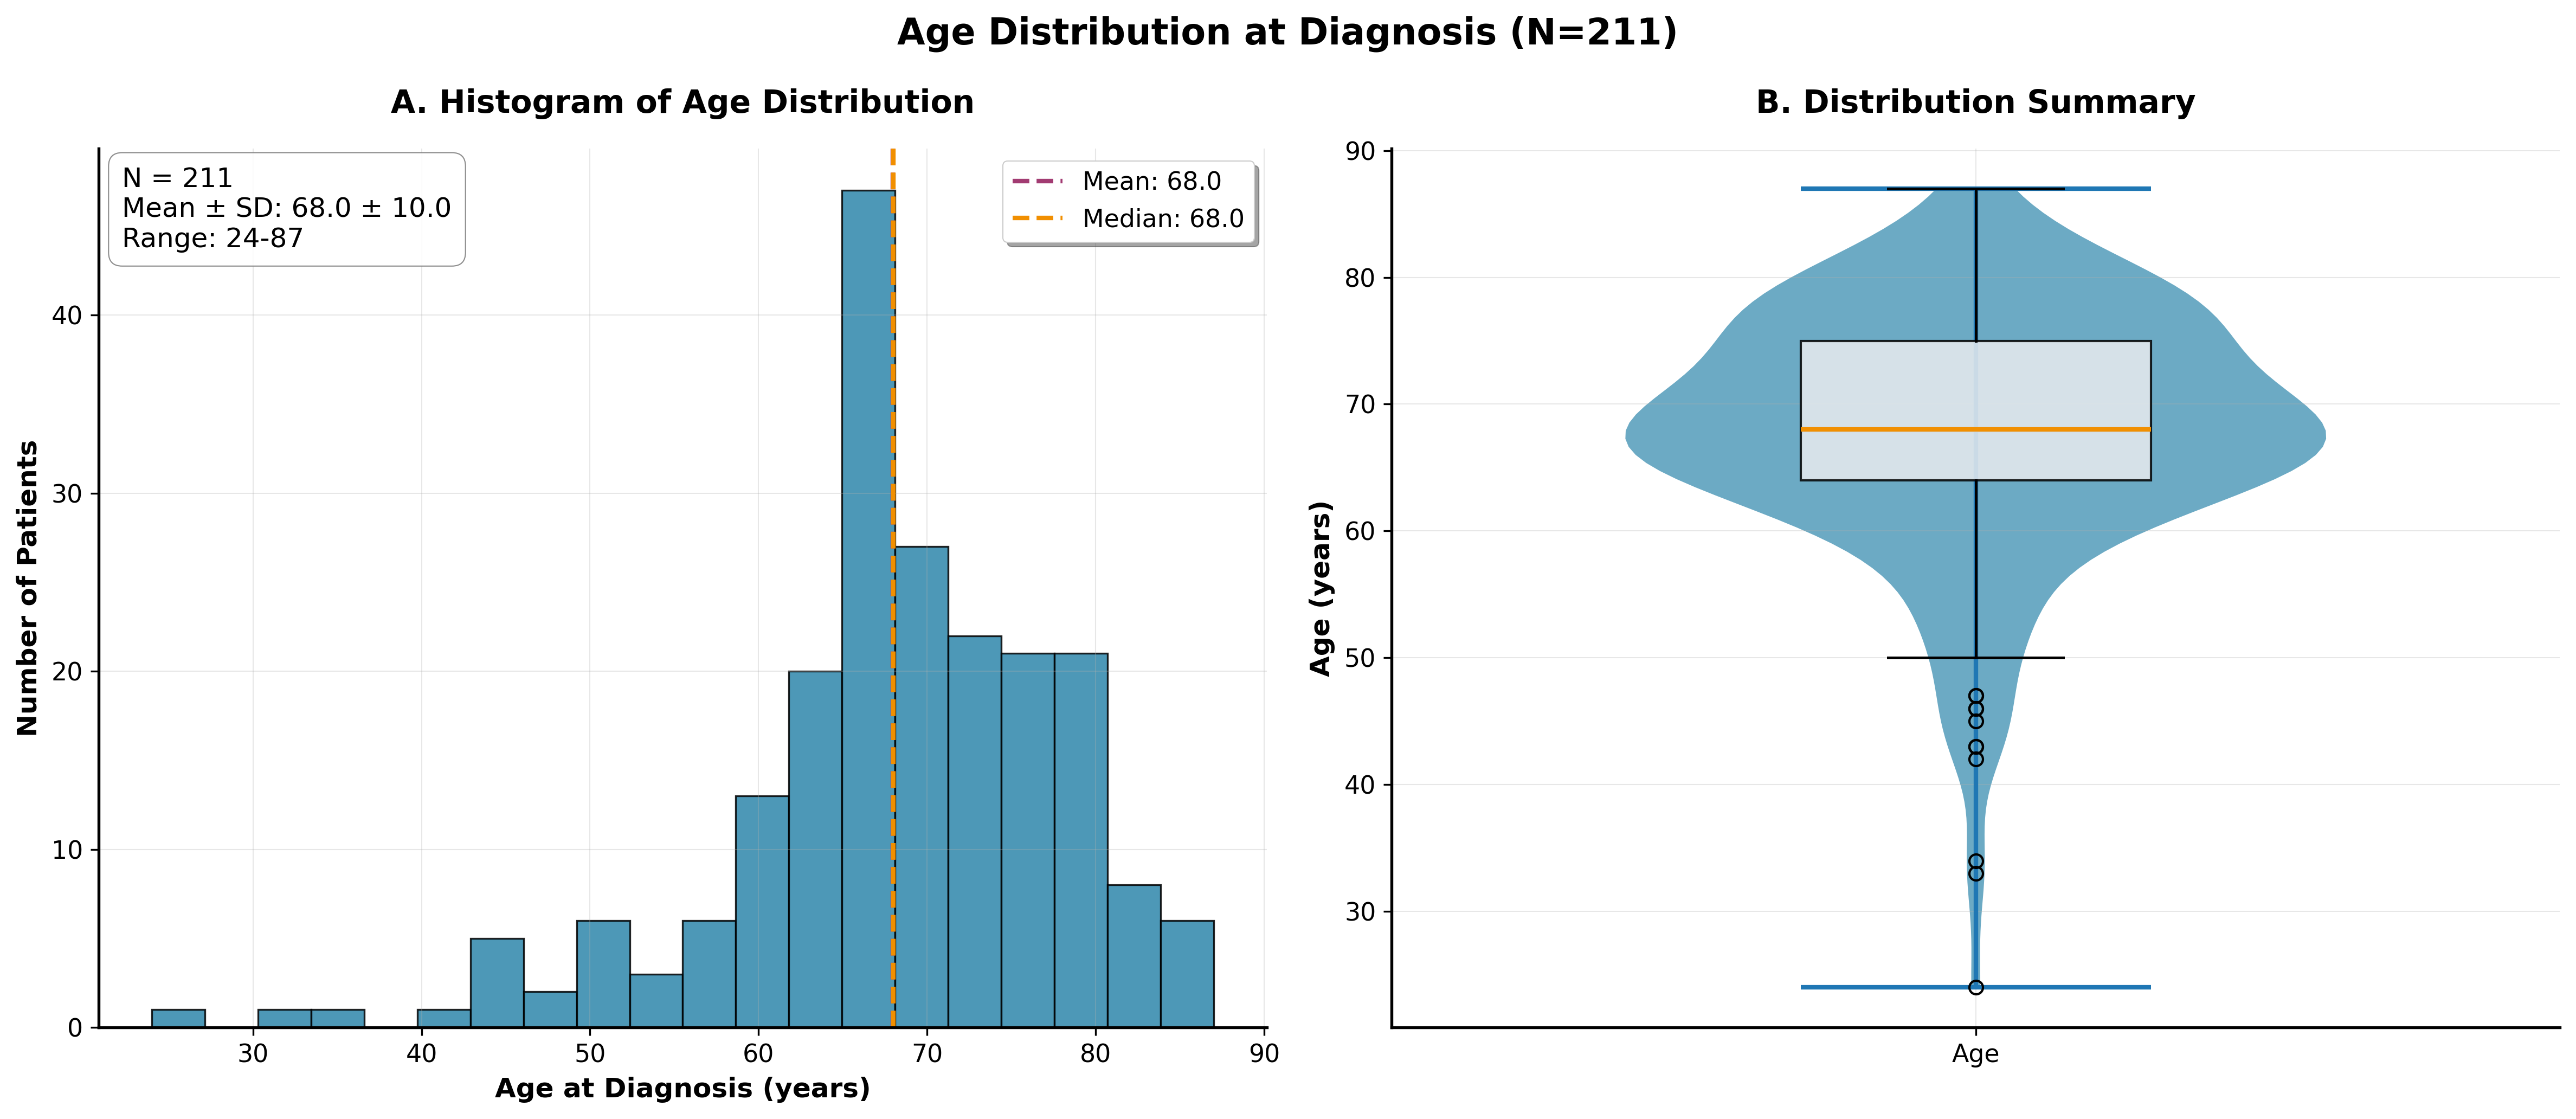


GENDER DISTRIBUTION
N=211 patients
--------------------------------------------------------------------------------


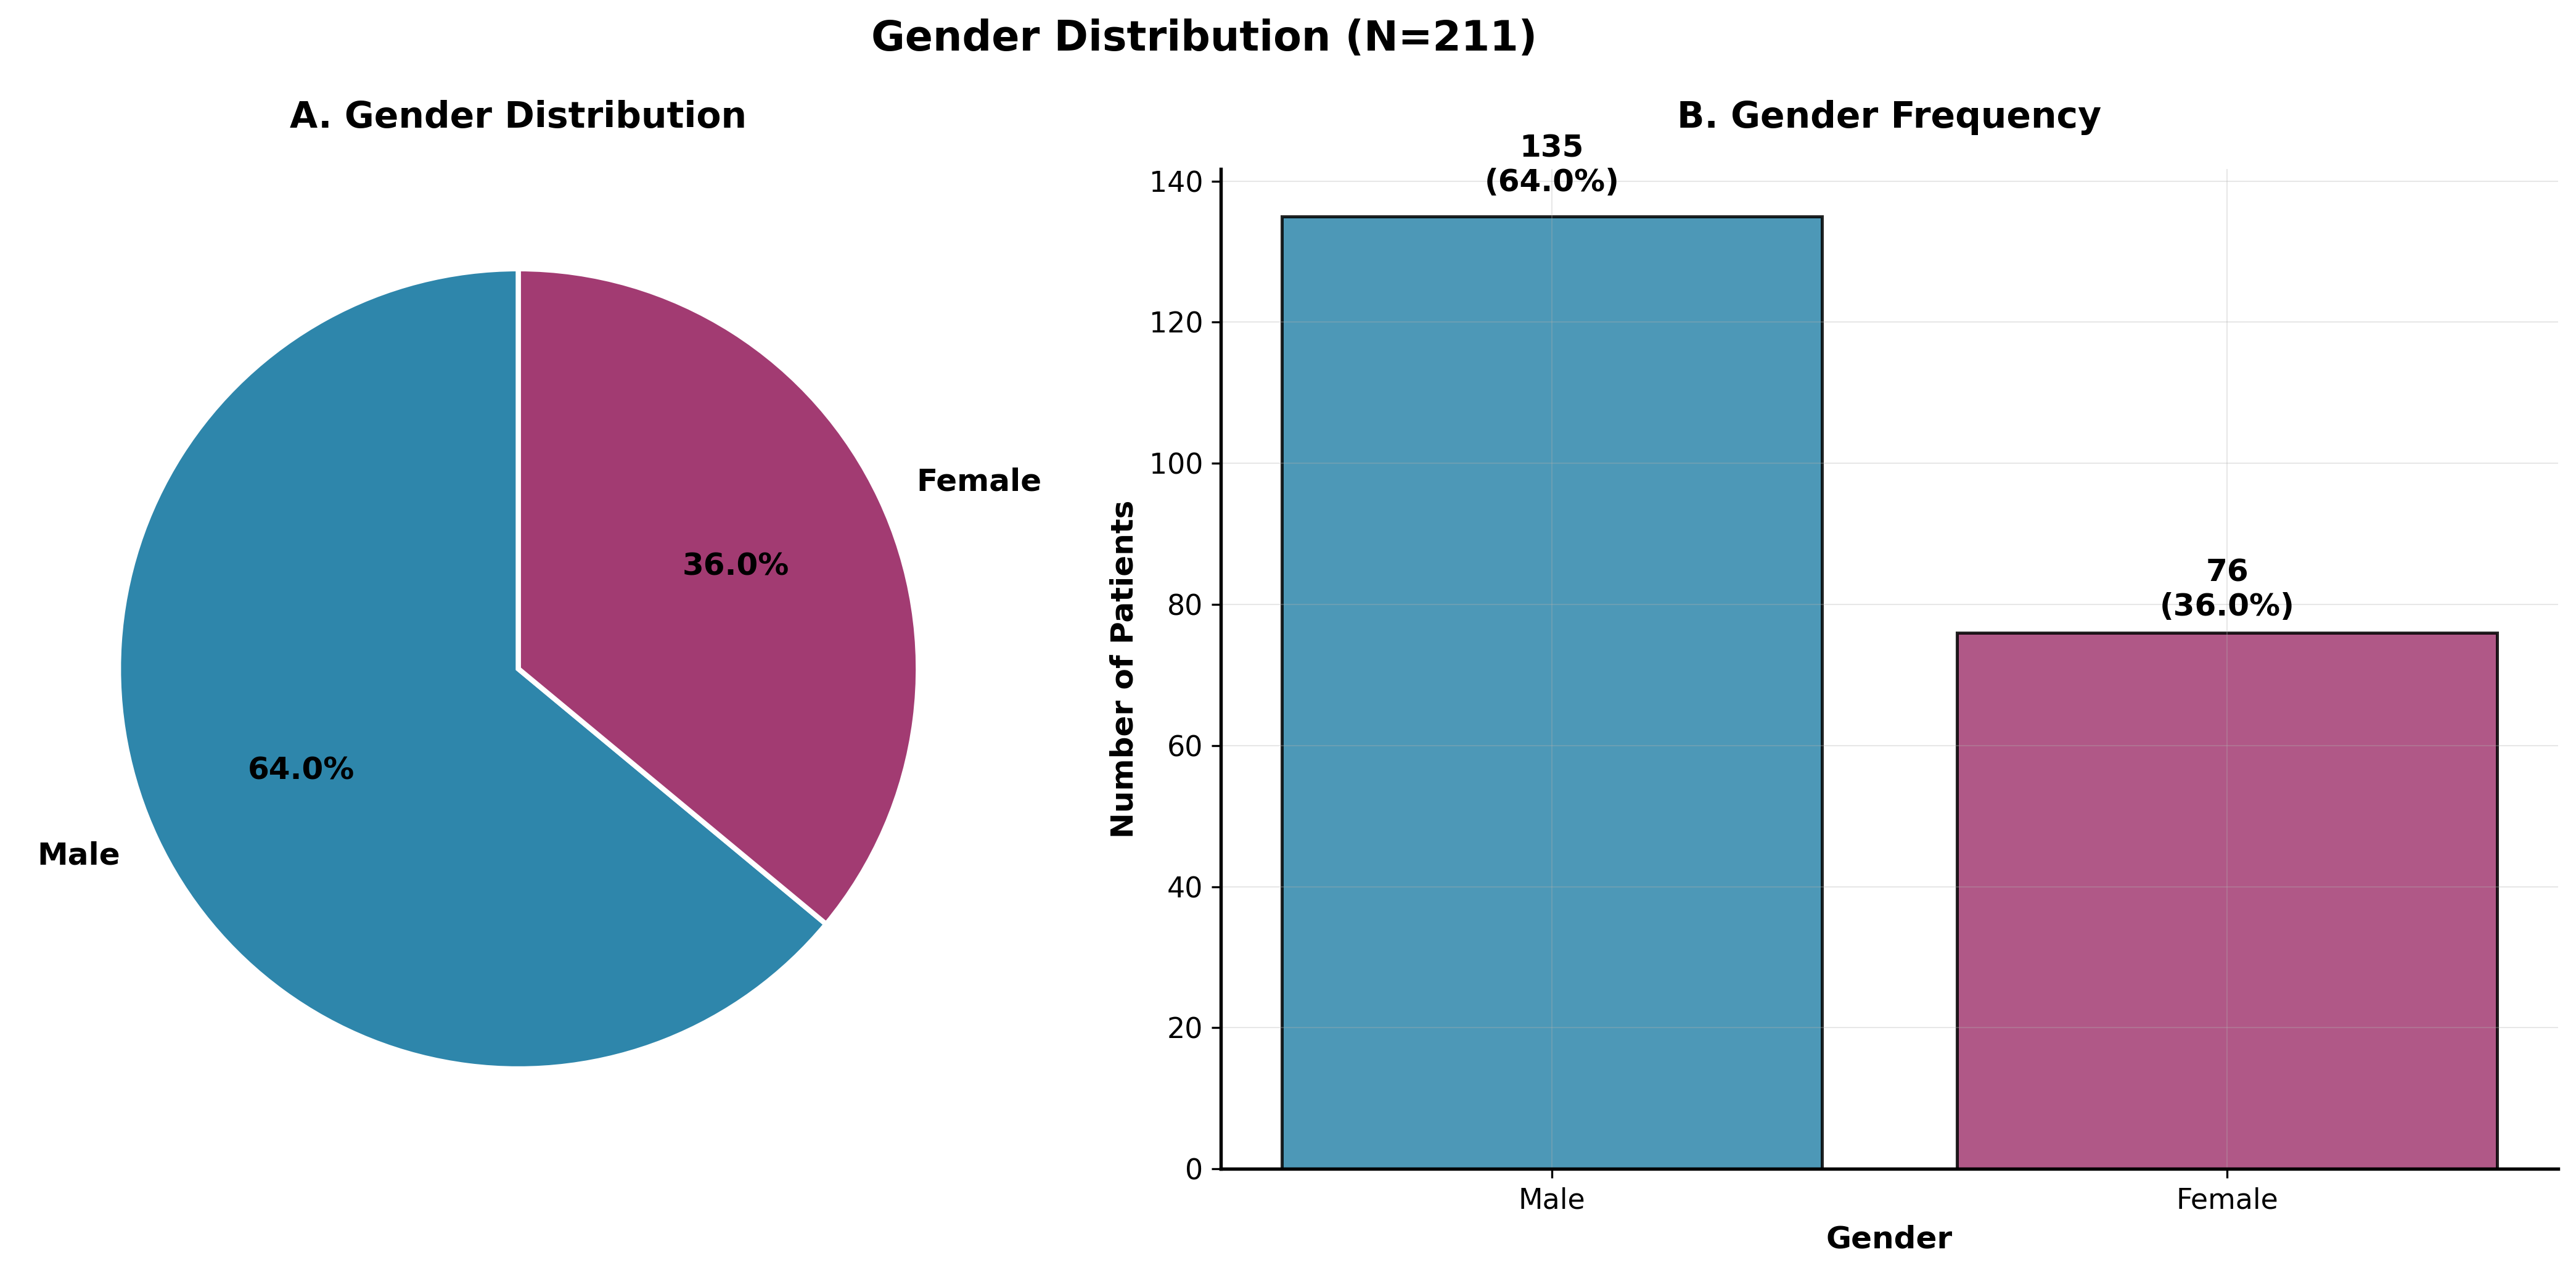


MOLECULAR MARKERS PREVALENCE
Analyzing 3 markers
--------------------------------------------------------------------------------


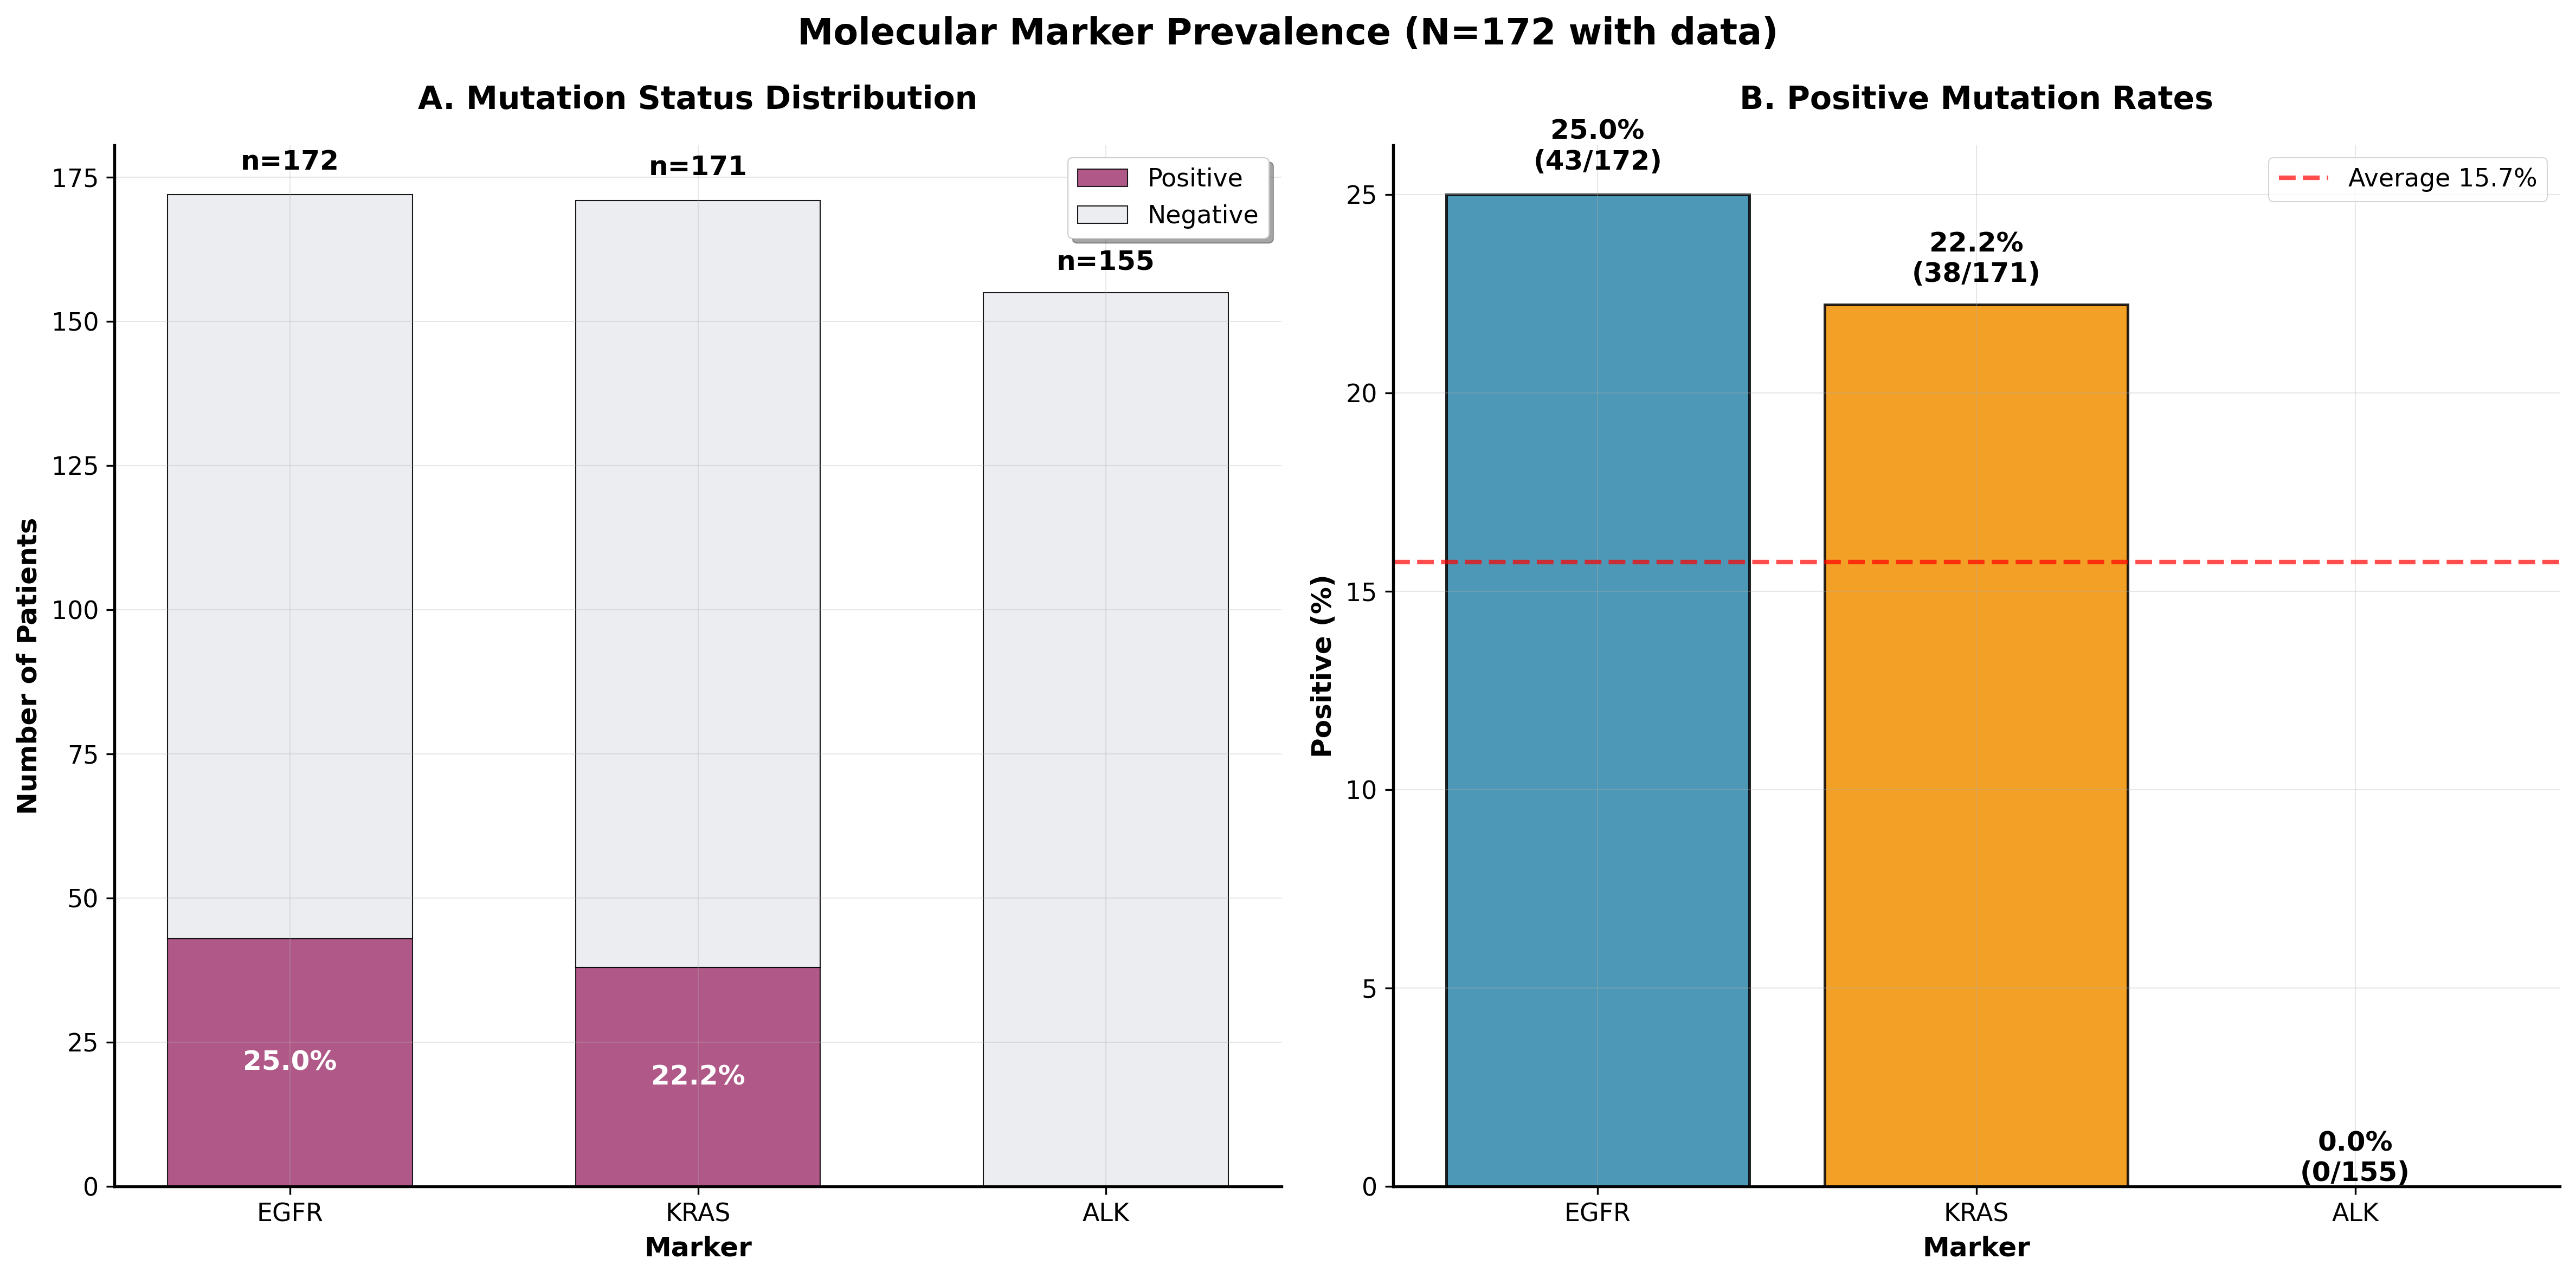


SURVIVAL ANALYSIS
Kaplan–Meier analysis (N=63, Events=63, Censored=0)
--------------------------------------------------------------------------------
Summary:
  N = 63   Events = 63   Censored = 0
  Median survival (days): 600
  1-year survival: 66.7%
  2-year survival: 42.9%
  Number at risk (days):
    t=   0: 63
    t= 365: 42
    t= 730: 27
    t=1095: 15
    t=1460: 5

Event table (head):
          removed  observed  censored  entrance  at_risk
event_at                                                
0.0             0         0         0        63       63
6.0             1         1         0         0       63
12.0            1         1         0         0       62
14.0            1         1         0         0       61
22.0            1         1         0         0       60
28.0            1         1         0         0       59


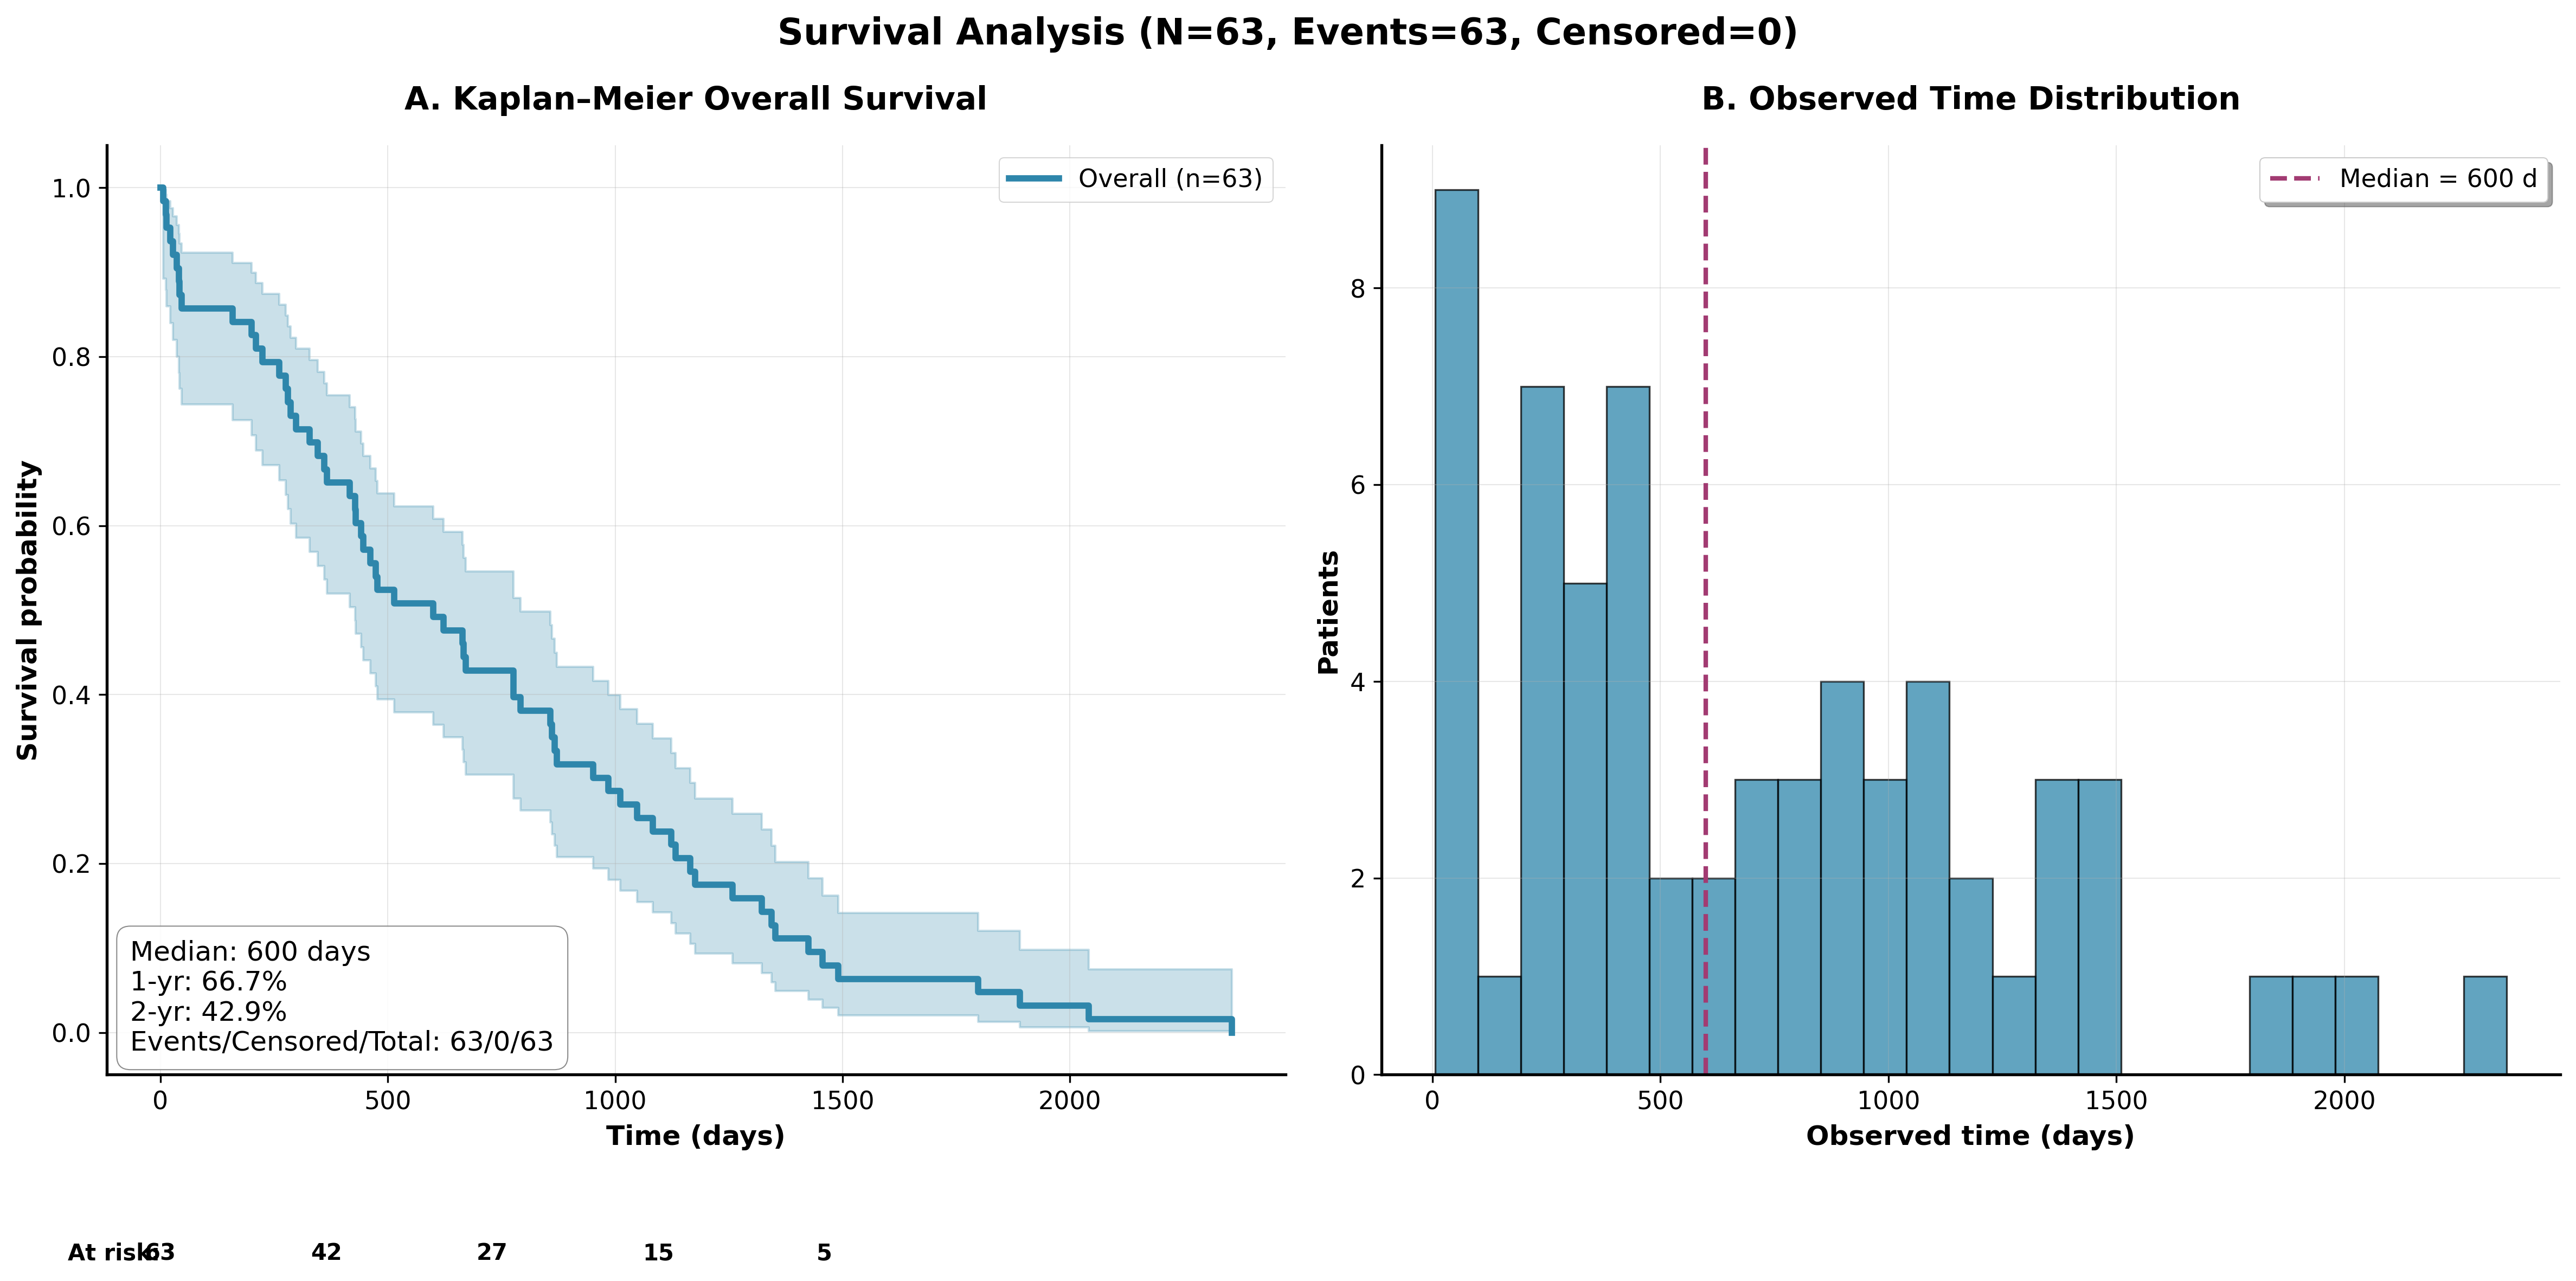


NOTE: No censored observations detected. If patients are alive, consider adding a 'Days to Last Follow-up' column so censoring can be shown.

SURVIVAL BY MOLECULAR MARKERS
Kaplan–Meier curves by mutation status (+ vs −) with censoring
--------------------------------------------------------------------------------


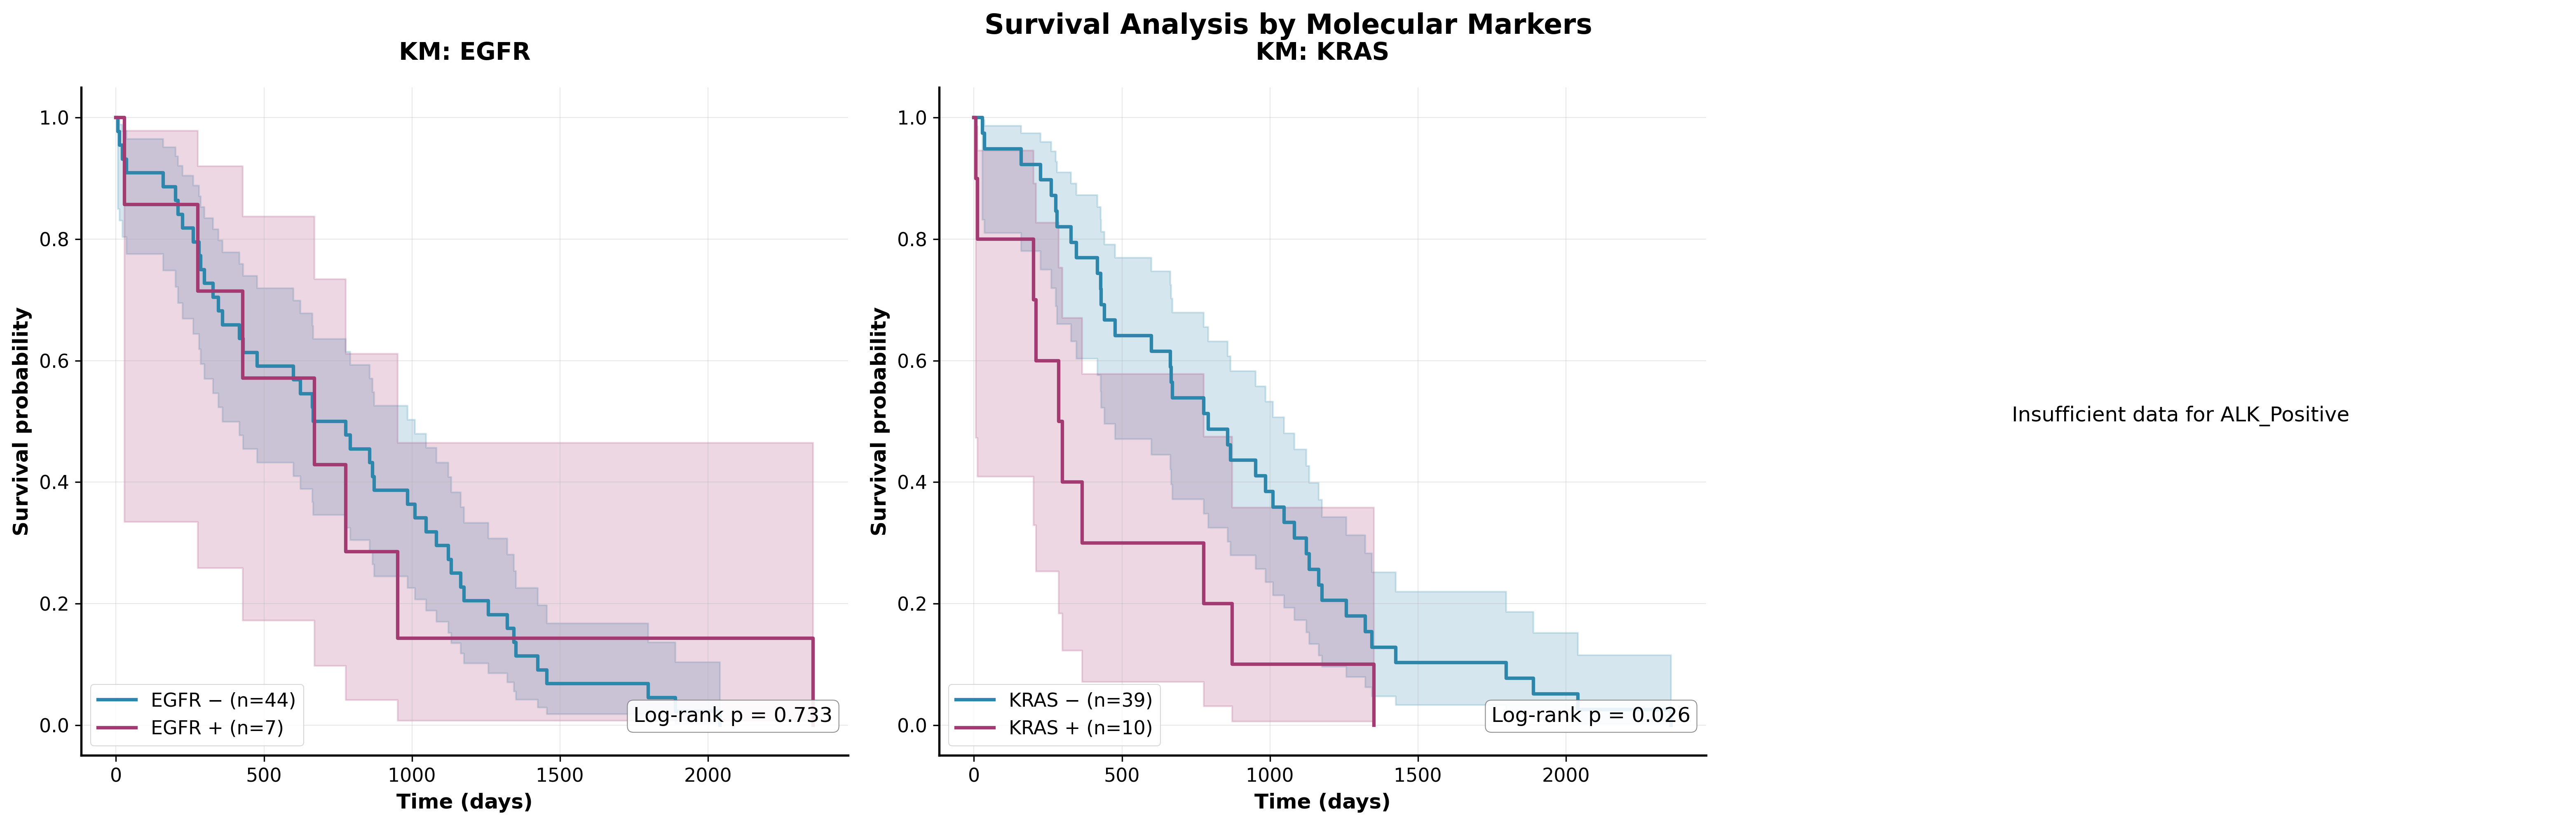


PIPELINE COMPLETE
Data source: NSCLCR01Radiogenomic_.csv
Saved figures:
  - age_distribution_plot.(png|pdf)
  - gender_distribution_plot.(png|pdf)
  - molecular_markers_plot.(png|pdf)
  - survival_analysis_plot.(png|pdf)
  - km_by_molecular_markers.(png|pdf)
